In [56]:
! pip install jupyter openpyxl seaborn matplotlib
! pip install -U sentence-transformers
! pip3 install alibi scikit-learn-extra

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [142]:
import datetime
import os
import sys
from pathlib import Path

import numpy as np

print(f"UTC now= '{datetime.datetime.utcnow().isoformat().split('.')[0]}'")

print(f'Virtualenv used: {sys.executable}')

import pandas as pd
import ast
import pickle

from sklearn.cluster import KMeans

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer, util

import xgboost as xgb

from alibi.explainers import AnchorText
from alibi.utils.download import spacy_model

UTC now= '2022-05-03T18:18:33'
Virtualenv used: /usr/bin/python3


In [91]:
def _save_pandas_pickle(df, outfile, results_folder):
  if results_folder:
    results_folder_local = f"{str(Path('~').expanduser().resolve())}/{results_folder}"
    # results_folder_local = results_folder
  else:
    results_folder_local = f"{str(Path('~').expanduser().resolve())}/data"
  Path(results_folder_local).mkdir(parents=True, exist_ok=True)
  fname = f"{results_folder_local}/{outfile}.pickle"
  print(fname)
  # df.to_pickle(fname)
  with open(fname, 'wb') as f:
    pickle.dump(df, f)


def get_LSA(df, column_to_ommit, how_many_dimmension):
  svd = TruncatedSVD(how_many_dimmension) # >~ 70%
  normalizer = Normalizer(copy=False)
  lsa = make_pipeline(svd, normalizer)

  df_edges_lsa = pd.DataFrame(lsa.fit_transform(df.loc[:, df.columns != column_to_ommit]))
  print(f"explained variance perc = {svd.explained_variance_ratio_.sum()*100}%")

  df_edges_lsa = pd.concat([df['article_which_cities'], df_edges_lsa], axis=1, join="inner")
  df_edges_lsa['cluster_kmeans'] = -1
  return df_edges_lsa


def k_means(df, column_to_ommit, how_many_clusters):
  kmeans = KMeans(n_clusters=how_many_clusters, random_state=2022).fit(df.loc[:, (df.columns != column_to_ommit) & (df.columns != 'cluster_kmeans')])
  # kmeans.labels_
  # print(pd.DataFrame(kmeans.cluster_centers_).reset_index())
  # print(pd.DataFrame(kmeans.cluster_centers_).reset_index()['index'])
  df['cluster_kmeans'] = kmeans.labels_
  # df_only_one_hots = df.loc[:, (df.columns != 'article_which_cities') & (df.columns != 'cluster_kmeans')]
  # df[['article_which_cities', 'cluster_kmeans']]
  return df


def get_TSNE_and_PCA_embeddings(df_edges, column_to_ommit):
  df_edges_independent_vars = df_edges.loc[:, (df_edges.columns != column_to_ommit) & (df_edges.columns != 'cluster_kmeans')]

  df_tsne = pd.DataFrame(TSNE(n_components=2).fit_transform(df_edges_independent_vars))
  df_tsne['cluster'] = df_edges['cluster_kmeans']
  df_tsne.columns = ['x1', 'x2', 'cluster']
  df_tsne['article_which_cities'] = df_edges['article_which_cities']

  df_pca = pd.DataFrame(PCA(n_components=2).fit_transform(df_edges_independent_vars))
  df_pca['cluster'] = df_edges['cluster_kmeans']
  df_pca.columns = ['x1', 'x2', 'cluster']
  df_pca['article_which_cities'] = df_edges['article_which_cities']

  scaler = MinMaxScaler()
  df_tsne[['x1', 'x2']] = scaler.fit_transform(df_tsne[['x1', 'x2']])
  df_pca[['x1', 'x2']] = scaler.fit_transform(df_pca[['x1', 'x2']])

  return df_tsne, df_pca


def wrap_by_word(s, n):
  '''returns a string where \\n is inserted between every n words'''
  a = s.split()
  ret = ''
  for i in range(0, len(a), n):
    ret += ' '.join(a[i:i+n]) + '\n'

  return ret

# x = wrap_by_word('There is a dog and fox fighting in the park and there is an apple falling down.', 4)
# print(x)
def get_article_info(df_with_article_which_cities_column, column):
  df_nodes_cp = df_nodes.copy()
  df_nodes_cp['article_which_cities'] = df_nodes_cp['ID'].apply(lambda x: f"{x:02d}")
  df_merged = df_with_article_which_cities_column.merge(df_nodes_cp, on='article_which_cities', how='left')

  return df_merged['article_which_cities'] + " (" + df_merged['Year'].apply(lambda x: str(x)) + ") " + ": \n" + df_merged[column].apply(lambda x: wrap_by_word(x, 3))

# get_article_info(df_tsne_lsa, column='Title')

def label_point(x, y, val, ax, factor):
  a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  for i, point in a.iterrows():
    ax.text(point['x'] + 1*factor, point['y'] - 10*factor, str(point['val']))


def visualise_clusters(df_2d_embedding, factor=1/200):
  _fig, _ax = plt.subplots(1, 1, figsize=(12*2,6*2))
  sns.scatterplot(data=df_2d_embedding, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, s=120, palette="deep", ax=_ax)
  label_point(df_2d_embedding['x1'], df_2d_embedding['x2'], get_article_info(df_2d_embedding, column='Title'), _ax, factor)
  # display(_fig)


In [92]:
# df_nodes = pd.read_excel('/media/mmozolewski/m.mozolewski@gma/Documents/Doktorat/Parisa/xai-survey/RC6 nodes info(Abstract).xlsx', sheet_name=0)
# df_edges = pd.read_excel('/media/mmozolewski/m.mozolewski@gma/Documents/Doktorat/Parisa/xai-survey/Data.xlsx', sheet_name=0)
df_nodes = pd.read_excel('notebooks/xai-survey/RC6 nodes info(Abstract).xlsx', sheet_name=0)
df_edges = pd.read_excel('notebooks/xai-survey/Data.xlsx', sheet_name=0)

In [4]:
df_nodes['Title_and_Abstract'] = df_nodes['Title'] + ' ' + df_nodes['Abstract']
df_nodes[['ID', 'Title', 'Abstract', 'CitationCount', 'RepetitionCount']]

,ID,Title,Abstract,CitationCount,RepetitionCount
0,1,"""Why Should I Trust You?"": Explaining the Pred...","Despite widespread adoption, machine learning ...",5799,17
1,2,On Pixel-Wise Explanations for Non-Linear Clas...,Understanding and interpreting classification ...,1848,15
2,4,A Unified Approach to Interpreting Model Predi...,Understanding why a model makes a certain pred...,3798,13
3,5,Axiomatic Attribution for Deep Networks,We study the problem of attributing the predic...,1749,13
4,7,Visualizing and Understanding Convolutional Ne...,Large Convolutional Network models have recent...,10818,11
5,8,Deep Inside Convolutional Networks: Visualisin...,This paper addresses the visualisation of imag...,3895,11
6,9,Grad-CAM: Visual Explanations from Deep Networ...,We propose a technique for producing ‘visual e...,3827,11
7,11,Understanding Black-box Predictions via Influe...,How can we explain the predictions of a black-...,1268,11
8,12,Anchors: High-Precision Model-Agnostic Explana...,We introduce a novel model-agnostic system tha...,746,11
9,13,How to Explain Individual Classification Decis...,After building a classifier with modern tools ...,655,10


In [5]:
df_nodes.loc[df_nodes['Abstract'].isna(), ]

,ID,Title,Year,CitationCount,RepetitionCount,Abstract
28,36,Feature Visualization,1994,513,6,NaN


In [6]:
df_edges.loc[(df_edges['node 1']==36) | (df_edges['node 2']==36), ]

,node 1,node 2,link type
148,50,36,['methodology']


In [93]:
# print(df_edges['link type'].dtype)
# df_edges.loc[32, 'link type'][0]
# ast.literal_eval(df_edges.loc[32, 'link type'])
df_edges['link type'] = df_edges['link type'].apply(lambda x: "['unknown']" if x == "[]" else x)
df_edges['link type'] = df_edges['link type'].apply(lambda x: ast.literal_eval(x))
df_edges

,node 1,node 2,link type
0,9,1,[unknown]
1,15,1,[unknown]
2,49,2,[unknown]
3,2,7,[unknown]
4,5,7,[unknown]
...,...,...,...
153,35,51,[methodology]
154,51,2,[result]
155,50,7,[result]
156,51,19,[result]


In [ ]:
# Plan :
# 4 relacje
# 50 artów
#
# id | is_methodology_01 | is_result_01 | is_result_01 |
# 00       true                false

# Opcja: SVD (LSA) -> jak PCA, TF-IDF
# Normalizacja
# k-means
# KnAC (objaśnienia na abstraktach)

In [5]:
df_edges_flatten = []
for index, row in df_edges.iterrows():
  for link_type in row['link type']:
    df_edges_flatten.append((f"{row['node 1']:02d}", f"{row['node 2']:02d}_{link_type}", row['node 1'], row['node 2'], link_type))
df_edges_flatten = pd.DataFrame(df_edges_flatten)
df_edges_flatten.sort_values(by=[2, 3, 4], inplace=True)
df_edges_flatten

,0,1,2,3,4
152,01,13_background,1,13,background
154,01,13_methodology,1,13,methodology
153,01,13_result,1,13,result
72,01,20_background,1,20,background
73,01,20_methodology,1,20,methodology
...,...,...,...,...,...
112,52,16_background,52,16,background
113,52,16_methodology,52,16,methodology
178,52,19_background,52,19,background
120,52,25_background,52,25,background


In [6]:
# pd.pivot_table(df_edges_flatten, index=0, values=2, columns=1, aggfunc='-'.join)
df_edges_flatten_one_hot = pd.get_dummies(df_edges_flatten[1])
df_edges_flatten_one_hot = pd.concat([df_edges_flatten, df_edges_flatten_one_hot], axis=1, join="inner")
df_edges_flatten_one_hot

,0,1,2,3,4,01_background,01_methodology,01_result,01_unknown,02_background,...,45_methodology,46_background,46_methodology,49_background,49_methodology,49_unknown,51_background,51_methodology,52_background,52_methodology
152,01,13_background,1,13,background,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,01,13_methodology,1,13,methodology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153,01,13_result,1,13,result,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72,01,20_background,1,20,background,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73,01,20_methodology,1,20,methodology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,52,16_background,52,16,background,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,52,16_methodology,52,16,methodology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178,52,19_background,52,19,background,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120,52,25_background,52,25,background,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## One-hot features

In [7]:
df_edges_one_hot = df_edges_flatten_one_hot.groupby(0).agg(lambda x: x.sum()).reset_index()
df_edges_one_hot.rename(columns={0: "article_which_cities"}, inplace=True)
del df_edges_one_hot[1]
del df_edges_one_hot[2]
del df_edges_one_hot[3]
del df_edges_one_hot[4]
df_edges_one_hot['cluster_kmeans'] = -1
df_edges_one_hot

,article_which_cities,01_background,01_methodology,01_result,01_unknown,02_background,02_methodology,02_result,02_unknown,04_methodology,...,46_background,46_methodology,49_background,49_methodology,49_unknown,51_background,51_methodology,52_background,52_methodology,cluster_kmeans
0,01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
2,04,0,1,0,0,0,1,0,0,0,...,0,1,1,1,0,0,0,0,0,-1
3,05,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,-1
4,07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
5,08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
6,09,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
7,11,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1
8,12,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
9,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1


## LSA features on One-HOT

In [41]:
df_edges_lsa = get_LSA(df_edges_one_hot, 'article_which_cities', 12)
df_edges_lsa

explained variance perc = 75.73133641188615%


,article_which_cities,0,1,2,3,4,5,6,7,8,9,10,11,cluster_kmeans
0,01,0.591077,-0.387955,0.063095,0.051943,0.466529,0.060713,0.121184,-0.341595,-0.029250,0.031337,0.319045,0.192624,-1
1,02,0.759892,0.186948,-0.245490,0.180745,-0.241450,0.102171,-0.257773,-0.057141,0.241110,0.014495,0.246077,0.193220,-1
2,04,0.749191,-0.259024,0.093061,0.122248,-0.067509,-0.054140,0.355978,0.111782,0.078093,0.368084,-0.140841,-0.199724,-1
3,05,0.551654,0.233611,-0.188424,0.520092,0.422867,-0.007188,-0.304441,0.130453,0.031020,-0.163057,-0.095905,-0.098929,-1
4,07,0.907812,-0.299807,-0.065738,-0.048476,-0.124150,0.000563,-0.165749,-0.117734,0.031730,0.022777,-0.042080,-0.138843,-1
5,08,0.846796,-0.196408,-0.035290,-0.317484,-0.178786,0.201318,0.081996,0.092404,-0.052368,-0.109915,0.190951,-0.057253,-1
6,09,0.765790,-0.113590,-0.111554,0.382303,-0.257556,-0.182690,-0.276983,-0.103502,-0.041346,-0.168897,0.129500,-0.088966,-1
7,11,0.892926,-0.160796,0.070553,0.139975,-0.042697,-0.114658,-0.255186,0.030309,-0.155480,-0.020455,-0.154632,-0.150819,-1
8,12,0.696441,-0.300288,0.225282,0.066906,0.519703,-0.089557,0.100668,-0.075332,-0.236270,0.075945,0.024368,0.116033,-1
9,13,0.783271,-0.469491,-0.020582,-0.125738,-0.114343,0.007102,-0.093108,-0.071343,0.121043,0.085566,-0.252178,0.193338,-1


## Sentence-BERT embeddings

In [201]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [202]:
df_edges_bert = pd.DataFrame(model.encode(df_nodes['Abstract'].tolist()))
df_edges_bert = pd.concat([df_nodes[['ID']], df_edges_bert], axis=1, join="inner").rename(columns={'ID':'article_which_cities'})
df_edges_bert['article_which_cities'] = df_edges_bert['article_which_cities'].apply(lambda x: f"{x:02d}")
df_edges_bert.head(3)

,article_which_cities,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,01,-0.000553,-0.018878,0.005200,-0.041082,0.105269,-0.045668,0.038578,-0.008916,0.023942,...,-0.017968,-0.006445,0.014152,-0.011385,-0.030502,-0.032760,-0.005807,-0.049921,-0.027134,-0.033042
1,02,0.054277,-0.006851,0.035458,-0.003538,0.082228,-0.095527,0.015141,-0.038575,0.026256,...,-0.013977,0.081980,0.005427,-0.013312,-0.030893,-0.063076,-0.121146,-0.068730,-0.013837,0.066910
2,04,0.004317,-0.004644,-0.024705,-0.030372,0.107849,-0.061204,0.031549,0.002038,0.017995,...,-0.015788,0.013097,-0.027097,-0.008309,-0.052290,-0.009791,-0.062663,-0.008897,-0.041519,-0.012917


In [203]:
df_edges_bert = pd.merge(df_edges_one_hot['article_which_cities'], df_edges_bert, left_on='article_which_cities', right_on='article_which_cities')
df_edges_bert['cluster_kmeans'] = -1
df_edges_bert

,article_which_cities,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,cluster_kmeans
0,01,-0.000553,-0.018878,0.005200,-0.041082,0.105269,-0.045668,0.038578,-0.008916,0.023942,...,-0.006445,0.014152,-0.011385,-0.030502,-0.032760,-0.005807,-0.049921,-0.027134,-0.033042,-1
1,02,0.054277,-0.006851,0.035458,-0.003538,0.082228,-0.095527,0.015141,-0.038575,0.026256,...,0.081980,0.005427,-0.013312,-0.030893,-0.063076,-0.121146,-0.068730,-0.013837,0.066910,-1
2,04,0.004317,-0.004644,-0.024705,-0.030372,0.107849,-0.061204,0.031549,0.002038,0.017995,...,0.013097,-0.027097,-0.008309,-0.052290,-0.009791,-0.062663,-0.008897,-0.041519,-0.012917,-1
3,05,0.002560,0.011128,0.002151,-0.024552,0.079729,-0.009693,-0.009770,0.028755,0.055328,...,0.002256,-0.027147,-0.051365,0.013915,-0.016082,-0.065891,0.041484,-0.002915,0.015306,-1
4,07,-0.049904,-0.009731,-0.050840,-0.033299,0.073338,-0.043489,-0.058084,-0.011454,0.028668,...,0.030507,0.011908,-0.010923,-0.059956,-0.027306,-0.058569,0.014828,-0.011092,0.021681,-1
5,08,-0.025868,-0.004474,0.027387,-0.018476,0.076490,-0.055742,0.041232,0.032145,-0.016426,...,0.035038,-0.006214,-0.074798,-0.006485,-0.024918,-0.050014,-0.050590,-0.018540,0.013127,-1
6,09,0.010309,-0.033658,0.040180,-0.021090,0.075706,-0.020667,0.042318,0.038162,-0.000312,...,0.008208,-0.000204,-0.066119,-0.032306,-0.034639,-0.069052,0.025285,-0.013056,0.029847,-1
7,11,0.003816,0.001510,0.044903,-0.035133,0.046942,-0.032139,0.043377,-0.005317,-0.006181,...,0.016284,0.002833,-0.001493,-0.015539,-0.015297,-0.023632,-0.036976,-0.023497,-0.007580,-1
8,12,0.016873,0.012663,0.041604,-0.033831,0.044544,-0.062096,-0.020983,0.005886,0.056358,...,-0.008711,-0.045702,0.056886,-0.024806,-0.036273,-0.058977,-0.028191,-0.018777,-0.025684,-1
9,13,-0.018026,-0.025824,0.050376,-0.038768,0.071750,-0.027621,0.055036,0.018378,0.031026,...,0.037017,0.034202,-0.028098,-0.037571,-0.024671,-0.040424,-0.024535,0.003050,0.033438,-1


# LSA features on Sentence-BERT embeddings

In [207]:
df_edges_bert_lsa = get_LSA(df_edges_bert, 'article_which_cities', 13)
df_edges_bert_lsa

explained variance perc = 70.87125944484454%


,article_which_cities,0,1,2,3,4,5,6,7,8,9,10,11,12,cluster_kmeans
0,01,0.889578,0.388877,0.135377,0.001076,0.019113,0.030850,0.037863,-0.033177,-0.140982,-0.121928,-0.018653,0.009993,0.007509,-1
1,02,0.874676,0.031945,-0.088217,0.358965,0.090429,0.091559,0.069934,-0.208601,0.035851,-0.113357,-0.070249,-0.014412,-0.114197,-1
2,04,0.881151,0.361326,-0.055261,-0.165200,0.055217,-0.118816,-0.162201,0.048503,-0.114673,-0.056221,-0.006498,0.002570,-0.022018,-1
3,05,0.923169,-0.000419,-0.036415,-0.009120,-0.019836,-0.097371,-0.051575,0.309930,0.055776,0.065784,0.078720,-0.015934,-0.154494,-1
4,07,0.912303,-0.111167,-0.216787,-0.079294,-0.060929,-0.084060,0.192205,0.043551,-0.140442,0.064121,0.103510,0.014306,-0.132999,-1
5,08,0.888538,-0.168470,-0.321950,0.142561,-0.104133,-0.058815,0.080108,0.151442,-0.054277,-0.002989,0.005873,-0.097991,0.043537,-1
6,09,0.952741,-0.179492,-0.176097,-0.026569,-0.124161,0.014019,-0.020597,0.090857,0.042714,-0.042281,0.020814,0.002076,0.003080,-1
7,11,0.890049,0.393356,0.075154,0.034490,-0.154022,0.044988,0.041530,0.025184,-0.091593,-0.030245,0.005604,-0.089235,0.029015,-1
8,12,0.885427,0.338516,0.006566,-0.086890,-0.125012,0.034869,0.116978,0.050849,0.110706,0.050324,0.127195,0.168908,0.034956,-1
9,13,0.910402,0.317447,0.067697,0.145662,-0.046843,0.090350,-0.100722,0.011941,-0.087888,-0.107244,-0.001753,-0.006192,-0.068432,-1


# SpaCy embeddings

In [60]:
import spacy
# from alibi.utils.download import spacy_model

model_spacy = 'en_core_web_lg'
# spacy_model(model=model_spacy)
spacy_nlp = spacy.load(model_spacy)

In [198]:
df_edges_spacy = pd.DataFrame([doc.vector for doc in spacy_nlp.pipe([str(x)  for x in df_nodes['Title_and_Abstract'].tolist()])])
df_edges_spacy = pd.concat([df_nodes[['ID']], df_edges_spacy], axis=1, join="inner").rename(columns={'ID':'article_which_cities'})
df_edges_spacy['article_which_cities'] = df_edges_spacy['article_which_cities'].apply(lambda x: f"{x:02d}")
df_edges_spacy.head(3)

,article_which_cities,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,01,-0.068911,0.151543,-0.172546,-0.032493,-0.022817,0.040812,0.006652,-0.016672,0.015428,...,-0.197207,0.047715,0.002941,0.028072,-0.011173,-0.041955,-0.054938,-0.069410,0.003901,0.088995
1,02,-0.077607,0.130140,-0.142530,-0.047446,-0.024676,0.066013,0.039020,0.010698,0.014747,...,-0.241520,0.031506,0.023490,-0.012619,-0.006465,-0.025360,-0.036098,-0.035285,0.024876,0.129049
2,04,-0.055260,0.196113,-0.136203,-0.033908,-0.027316,0.020349,0.024967,-0.001510,0.006252,...,-0.192550,0.049244,0.011771,0.032078,-0.010825,-0.031603,-0.097646,-0.088258,-0.003174,0.110240


In [200]:
df_edges_spacy = pd.merge(df_edges_one_hot['article_which_cities'], df_edges_spacy, left_on='article_which_cities', right_on='article_which_cities')
df_edges_spacy['cluster_kmeans'] = -1
df_edges_spacy

,article_which_cities,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,cluster_kmeans
0,01,-0.068911,0.151543,-0.172546,-0.032493,-0.022817,0.040812,0.006652,-0.016672,0.015428,...,0.047715,0.002941,0.028072,-0.011173,-0.041955,-0.054938,-0.069410,0.003901,0.088995,-1
1,02,-0.077607,0.130140,-0.142530,-0.047446,-0.024676,0.066013,0.039020,0.010698,0.014747,...,0.031506,0.023490,-0.012619,-0.006465,-0.025360,-0.036098,-0.035285,0.024876,0.129049,-1
2,04,-0.055260,0.196113,-0.136203,-0.033908,-0.027316,0.020349,0.024967,-0.001510,0.006252,...,0.049244,0.011771,0.032078,-0.010825,-0.031603,-0.097646,-0.088258,-0.003174,0.110240,-1
3,05,-0.005107,0.134327,-0.199824,-0.053474,-0.032771,0.041122,0.034871,0.018464,0.011231,...,0.044808,-0.017295,0.014682,0.012507,-0.115217,-0.014394,-0.042813,-0.021338,0.118536,-1
4,07,-0.044680,0.160835,-0.113194,-0.053791,-0.007847,0.033931,0.033367,0.026113,0.010751,...,0.040736,0.027318,-0.011036,-0.001646,-0.076344,0.012596,-0.007521,-0.007806,0.102458,-1
5,08,-0.028235,0.128662,-0.108030,-0.087632,-0.001260,0.076431,0.013962,0.015385,-0.029339,...,0.032156,0.014085,0.020017,0.010323,-0.038134,-0.015000,0.010000,-0.088007,0.152268,-1
6,09,-0.077713,0.118375,-0.139208,0.002337,0.022478,0.048467,0.032314,-0.005575,-0.003615,...,0.028577,0.013559,0.030909,-0.040176,-0.022999,-0.037094,-0.058892,0.013081,0.076620,-1
7,11,-0.061432,0.193673,-0.133514,-0.006413,-0.036070,0.065468,0.045580,0.006146,0.001451,...,0.052237,0.013204,0.024447,-0.011739,-0.058604,-0.009451,-0.007631,0.015513,0.121458,-1
8,12,-0.096827,0.175132,-0.178732,-0.013123,-0.016492,0.013834,0.056677,0.087475,-0.021960,...,0.040194,0.023600,0.055996,-0.032833,-0.096308,-0.022670,-0.053241,0.071481,0.039604,-1
9,13,-0.058390,0.160565,-0.174977,-0.033091,0.015038,0.005410,-0.014452,-0.041362,0.018883,...,0.067716,-0.005097,-0.005800,0.025300,-0.028005,-0.074784,-0.044919,0.030405,0.085646,-1


# LSA for SpaCy

In [210]:
df_edges_spacy_lsa = get_LSA(df_edges_spacy, 'article_which_cities', 11)
df_edges_spacy_lsa

explained variance perc = 70.23255258334758%


,article_which_cities,0,1,2,3,4,5,6,7,8,9,10,cluster_kmeans
0,01,0.995069,0.077541,-0.007929,-0.016152,-0.003843,-0.030939,0.001421,0.035551,-0.018108,-0.030335,0.003833,-1
1,02,0.997922,-0.026270,-0.036316,0.016242,-0.002869,0.013014,-0.024440,-0.009715,-0.018959,0.012554,-0.022209,-1
2,04,0.995894,0.035977,-0.033019,0.016561,-0.019746,-0.059146,0.001586,0.004615,0.005731,-0.004544,-0.039634,-1
3,05,0.995071,0.018350,-0.027115,-0.031515,0.027543,-0.021024,-0.021387,-0.047856,-0.003838,-0.013895,0.060107,-1
4,07,0.993073,0.012129,0.016095,-0.025444,0.000574,-0.028266,0.076678,-0.001214,0.069463,-0.031234,-0.016463,-1
5,08,0.981548,-0.107404,0.076011,0.022304,0.013792,-0.039348,0.123048,0.012814,-0.028783,-0.026517,-0.013311,-1
6,09,0.980407,-0.025387,0.165212,-0.015525,-0.084713,-0.007005,0.001106,0.037207,-0.041231,0.017347,0.002975,-1
7,11,0.992667,0.003582,0.018295,-0.058983,-0.078550,0.015046,0.008655,0.022558,-0.016075,-0.024440,0.054311,-1
8,12,0.987470,0.049009,0.006654,-0.111287,-0.070792,0.004593,-0.043840,-0.029894,-0.032990,-0.026231,-0.021144,-1
9,13,0.987965,0.075061,-0.032978,-0.021056,0.092697,-0.076062,-0.046724,0.002598,0.008686,-0.009621,0.004881,-1


# K-means clustering

In [211]:
df_edges_one_hot = k_means(df_edges_one_hot, 'article_which_cities', 3)
df_edges_lsa = k_means(df_edges_lsa, 'article_which_cities', 3)
df_edges_bert = k_means(df_edges_bert, 'article_which_cities', 3)
df_edges_bert_lsa = k_means(df_edges_bert_lsa, 'article_which_cities', 3)
df_edges_spacy_lsa = k_means(df_edges_spacy_lsa, 'article_which_cities', 3)

In [212]:
df_tsne_one_hots, df_pca_one_hots = get_TSNE_and_PCA_embeddings(df_edges_one_hot, 'article_which_cities')
df_tsne_lsa, df_pca_lsa = get_TSNE_and_PCA_embeddings(df_edges_lsa, 'article_which_cities')
df_tsne_bert, df_pca_bert = get_TSNE_and_PCA_embeddings(df_edges_bert, 'article_which_cities')
df_tsne_bert_lsa, df_pca_bert_lsa = get_TSNE_and_PCA_embeddings(df_edges_bert_lsa, 'article_which_cities')
df_tsne_spacy_lsa, df_pca_spacy_lsa = get_TSNE_and_PCA_embeddings(df_edges_spacy_lsa, 'article_which_cities')

In [213]:
_save_pandas_pickle(df_tsne_one_hots, 'df_tsne_one_hots', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_pca_one_hots, 'df_pca_one_hots', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_tsne_lsa, 'df_tsne_lsa', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_pca_lsa, 'df_pca_lsa', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_tsne_bert, 'df_tsne_bert', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_pca_bert, 'df_pca_bert', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_tsne_bert_lsa, 'df_tsne_bert_lsa', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_pca_bert_lsa, 'df_pca_bert_lsa', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_tsne_spacy_lsa, 'df_pca_bert_lsa', "notebooks/xai-survey/clusters-embeddings")
_save_pandas_pickle(df_pca_spacy_lsa, 'df_pca_bert_lsa', "notebooks/xai-survey/clusters-embeddings")

/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_tsne_bert.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_pca_bert.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_tsne_bert_lsa.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_pca_bert_lsa.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_pca_bert_lsa.pickle
/home/mmozolewski/notebooks/xai-survey/clusters-embeddings/df_pca_bert_lsa.pickle


Text(0.5, 0.98, 'Clustering result: citations data (One-Hot, LSA) \n (visualized using TSNE2D vs. PCA2D)')

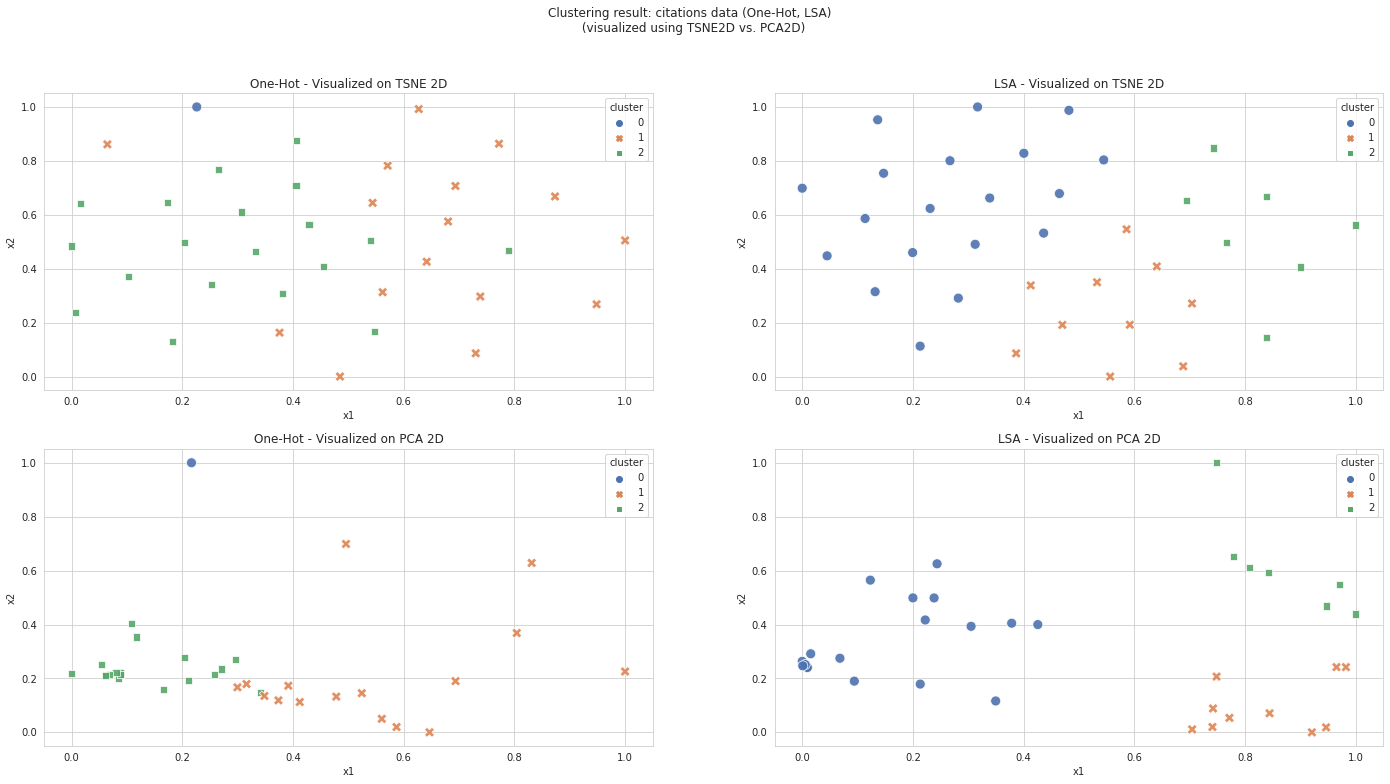

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(12*2,6*2))
sns.scatterplot(data=df_tsne_one_hots, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[0,0])
ax[0,0].set_title('One-Hot - Visualized on TSNE 2D')
sns.scatterplot(data=df_tsne_lsa, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[0,1])
ax[0,1].set_title('LSA - Visualized on TSNE 2D')
# sns.scatterplot(data=df_tsne_bert, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[0,2])
# ax[0,2].set_title('** BERT - Visualized on TSNE 2D')

sns.scatterplot(data=df_pca_one_hots, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1,0])
ax[1,0].set_title('One-Hot - Visualized on PCA 2D')
sns.scatterplot(data=df_pca_lsa, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1,1])
ax[1,1].set_title('LSA - Visualized on PCA 2D')
# sns.scatterplot(data=df_pca_bert, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1,2])
# ax[1,2].set_title('** BERT - Visualized on PCA 2D')

fig.suptitle('Clustering result: citations data (One-Hot, LSA) \n (visualized using TSNE2D vs. PCA2D)') #and abstracts (BERT)
# display(fig)

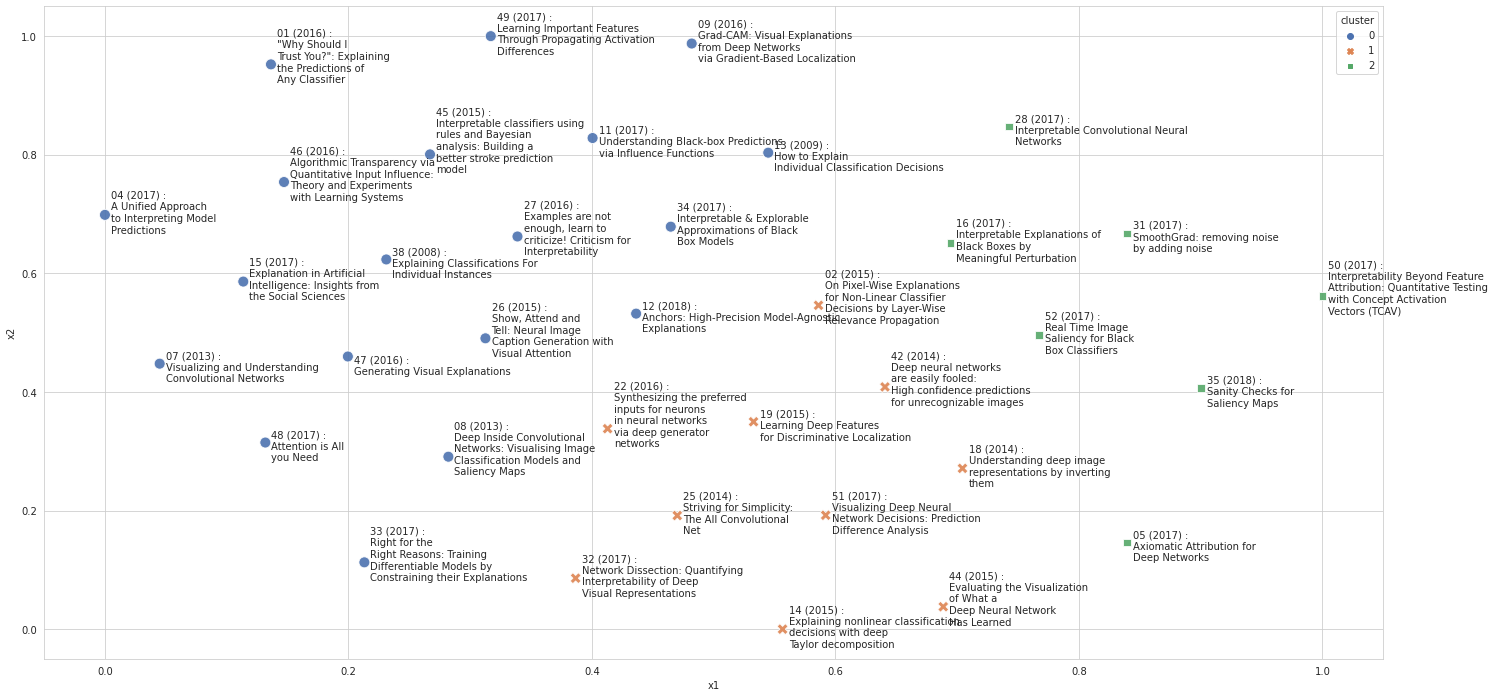

In [50]:
### some articles, like 20 does not cite any other article, so they are not on this graph ###
visualise_clusters(df_tsne_lsa)
# visualise_clusters(df_pca_lsa)

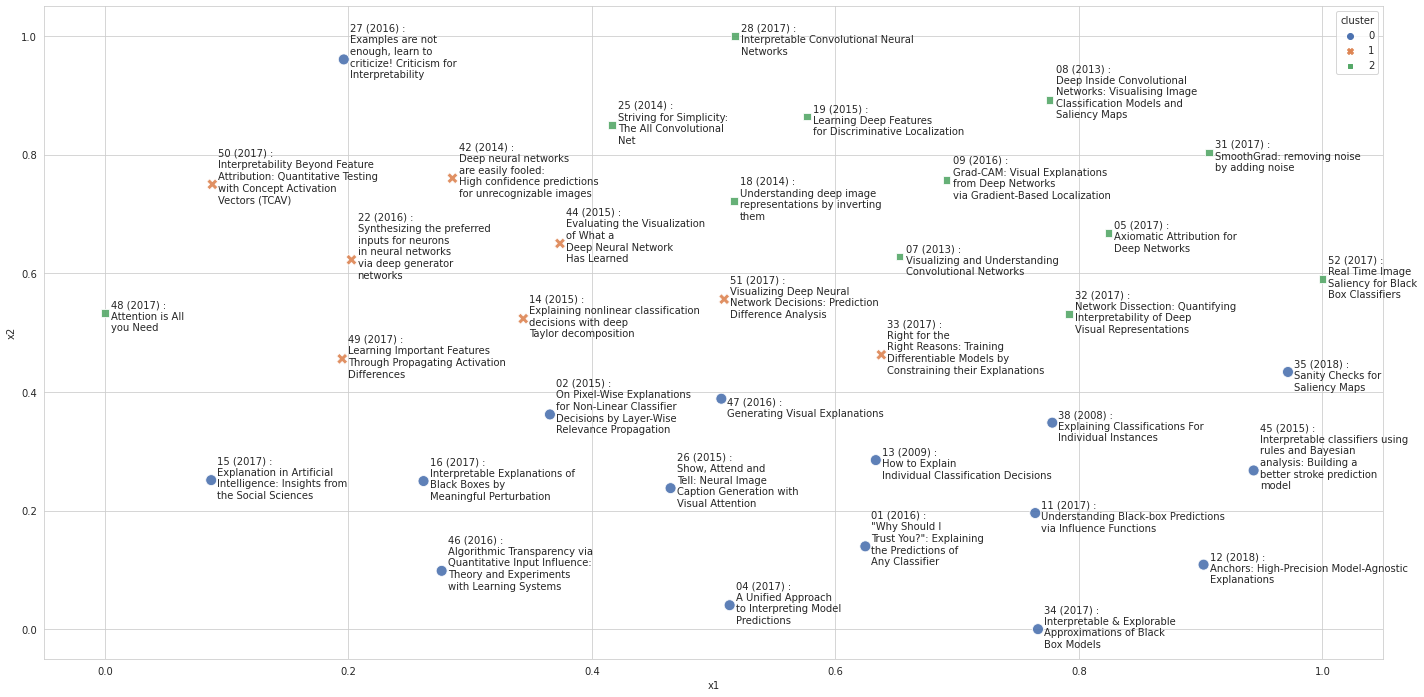

In [214]:
## clustering on BERT emmbedings - not good:
# visualise_clusters(df_tsne_bert)
visualise_clusters(df_tsne_bert_lsa)
# visualise_clusters(df_pca_bert)
# visualise_clusters(df_pca_bert_lsa)

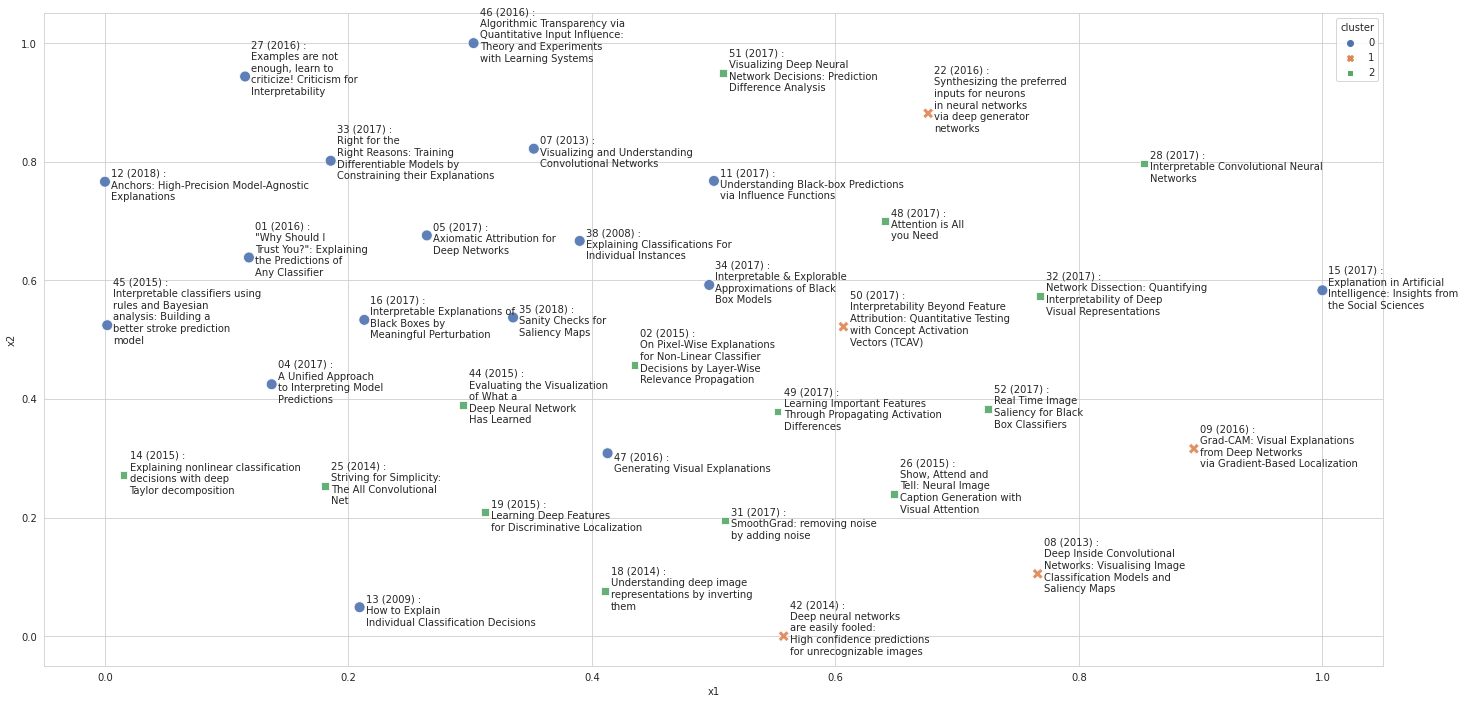

In [215]:
visualise_clusters(df_tsne_spacy_lsa)

# clustering on both citation data and BERT

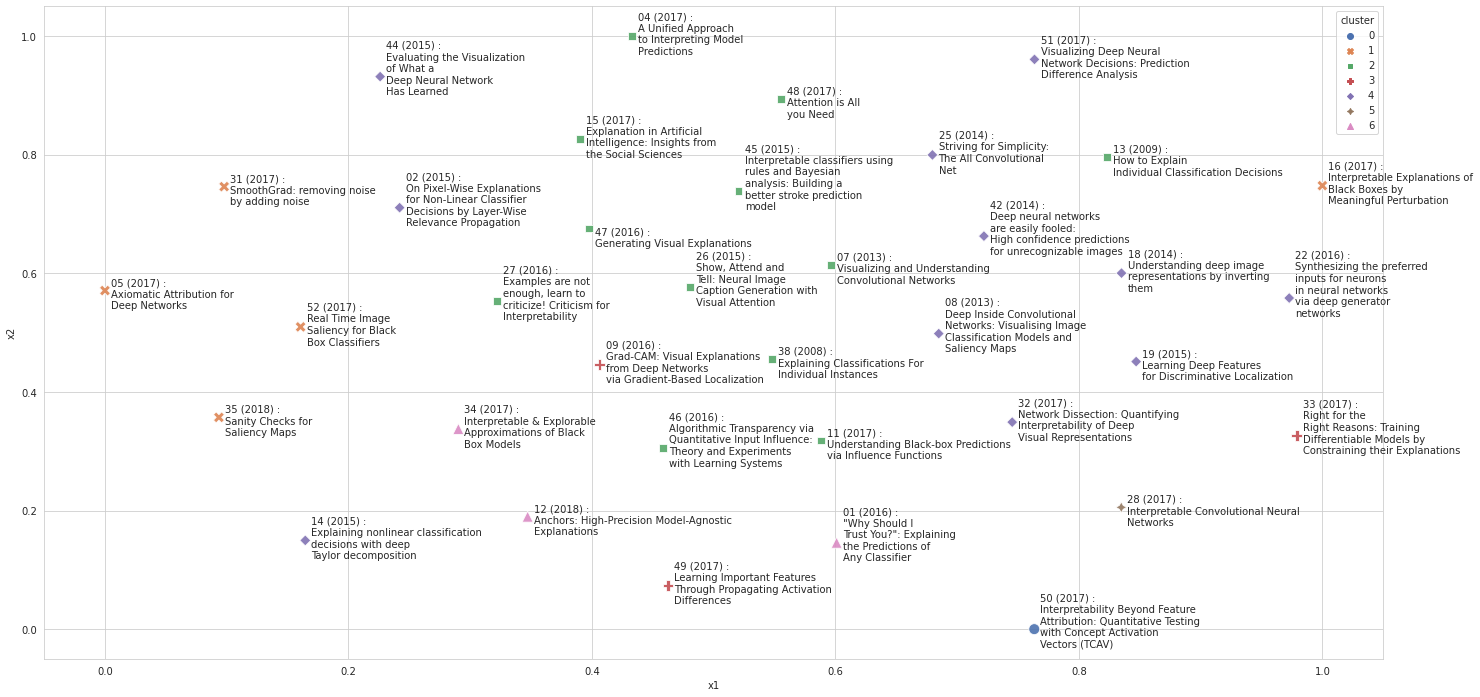

In [216]:
df_edges_bert_lsa_and_lsa = pd.concat([df_edges_bert_lsa, df_edges_lsa.loc[:, (df_edges_lsa.columns != 'article_which_cities') & (df_edges_lsa.columns != 'cluster_kmeans')]], axis=1)
df_edges_bert_lsa_and_lsa = k_means(df_edges_bert_lsa_and_lsa, 'article_which_cities', 7)
df_edges_bert_lsa_and_lsa_tsne, df_edges_bert_lsa_and_lsa_pca = get_TSNE_and_PCA_embeddings(df_edges_bert_lsa_and_lsa, 'article_which_cities')
# _save_pandas_pickle(df_edges_bert_lsa_and_lsa_tsne, 'df_edges_bert_lsa_and_lsa_tsne', "notebooks/xai-survey/clusters-embeddings")
# _save_pandas_pickle(df_edges_bert_lsa_and_lsa_pca, 'df_edges_bert_lsa_and_lsa_pca', "notebooks/xai-survey/clusters-embeddings")

visualise_clusters(df_edges_bert_lsa_and_lsa_tsne)
# df_edges_bert_lsa_and_lsa_tsne

# clustering on both citation data and spacy

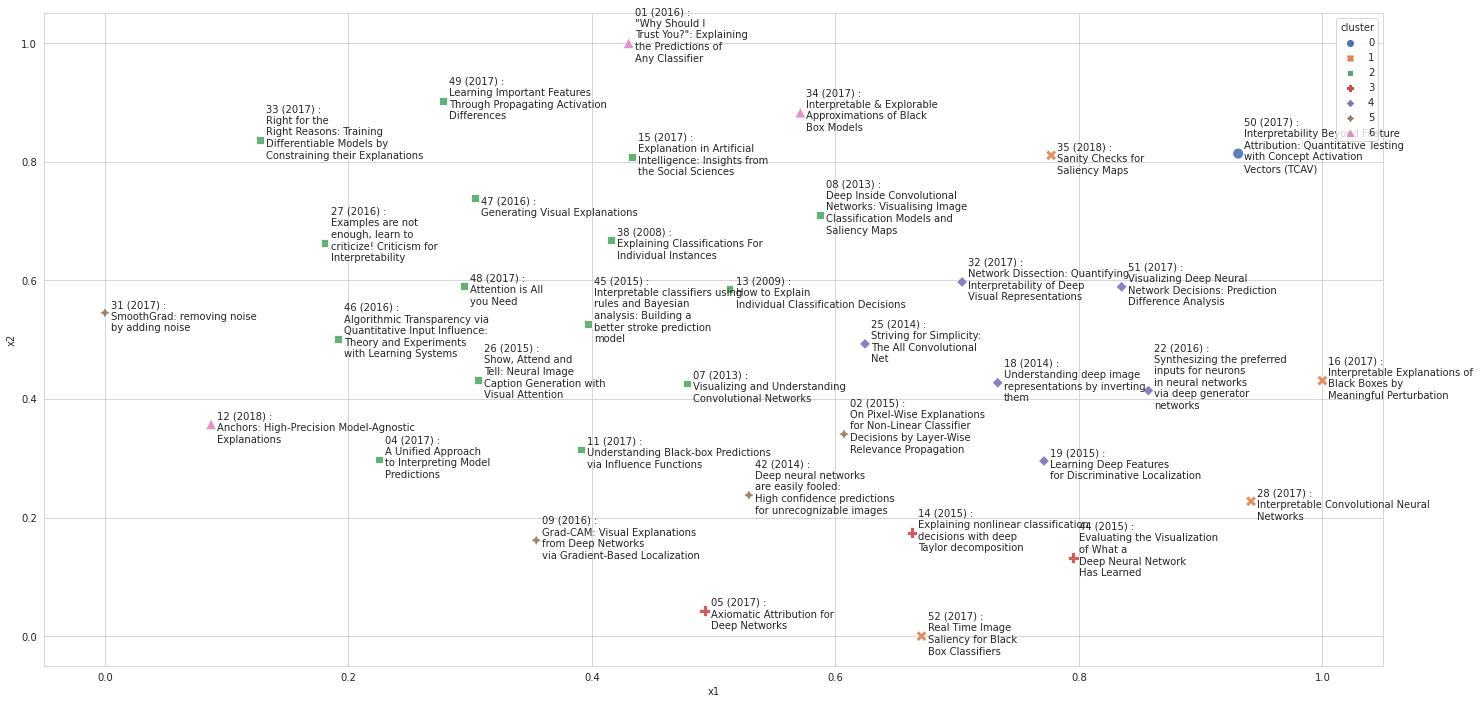

In [217]:
df_edges_spacy_lsa_and_lsa = pd.concat([df_edges_spacy_lsa, df_edges_lsa.loc[:, (df_edges_lsa.columns != 'article_which_cities') & (df_edges_lsa.columns != 'cluster_kmeans')]], axis=1)
df_edges_spacy_lsa_and_lsa = k_means(df_edges_spacy_lsa_and_lsa, 'article_which_cities', 7)
df_edges_spacy_lsa_and_lsa_tsne, df_edges_spacy_lsa_and_lsa_pca = get_TSNE_and_PCA_embeddings(df_edges_spacy_lsa_and_lsa, 'article_which_cities')
# _save_pandas_pickle(df_edges_spacy_lsa_and_lsa_tsne, 'df_edges_spacy_lsa_and_lsa_tsne', "notebooks/xai-survey/clusters-embeddings")
# _save_pandas_pickle(df_edges_spacy_lsa_and_lsa_pca, 'df_edges_spacy_lsa_and_lsa_pca', "notebooks/xai-survey/clusters-embeddings")

visualise_clusters(df_edges_spacy_lsa_and_lsa_tsne)

In [ ]:
# TODO :
# Zamiast BERT - TF-IDF, W2V
# clamp -> objaśnie klustw
# expert clusters from Parisa  -> knAC
# inxai -> dodac NLU, metryki

In [218]:
df_nodes

,ID,Title,Year,CitationCount,RepetitionCount,Abstract,ID-str,Title_and_Abstract
0,1,"""Why Should I Trust You?"": Explaining the Pred...",2016,5799,17,"Despite widespread adoption, machine learning ...",1,"""Why Should I Trust You?"": Explaining the Pred..."
1,2,On Pixel-Wise Explanations for Non-Linear Clas...,2015,1848,15,Understanding and interpreting classification ...,2,On Pixel-Wise Explanations for Non-Linear Clas...
2,4,A Unified Approach to Interpreting Model Predi...,2017,3798,13,Understanding why a model makes a certain pred...,4,A Unified Approach to Interpreting Model Predi...
3,5,Axiomatic Attribution for Deep Networks,2017,1749,13,We study the problem of attributing the predic...,5,Axiomatic Attribution for Deep Networks We stu...
4,7,Visualizing and Understanding Convolutional Ne...,2013,10818,11,Large Convolutional Network models have recent...,7,Visualizing and Understanding Convolutional Ne...
5,8,Deep Inside Convolutional Networks: Visualisin...,2013,3895,11,This paper addresses the visualisation of imag...,8,Deep Inside Convolutional Networks: Visualisin...
6,9,Grad-CAM: Visual Explanations from Deep Networ...,2016,3827,11,We propose a technique for producing ‘visual e...,9,Grad-CAM: Visual Explanations from Deep Networ...
7,11,Understanding Black-box Predictions via Influe...,2017,1268,11,How can we explain the predictions of a black-...,11,Understanding Black-box Predictions via Influe...
8,12,Anchors: High-Precision Model-Agnostic Explana...,2018,746,11,We introduce a novel model-agnostic system tha...,12,Anchors: High-Precision Model-Agnostic Explana...
9,13,How to Explain Individual Classification Decis...,2009,655,10,After building a classifier with modern tools ...,13,How to Explain Individual Classification Decis...


In [219]:
df_nodes['ID-str'] = df_nodes['ID'].apply(lambda x: f"{x:02d}")
df_edges_for_xai = pd.merge(df_edges_spacy_lsa_and_lsa.loc[:, ['article_which_cities', 'cluster_kmeans']], df_nodes[['ID-str', 'Title', 'Abstract']], left_on='article_which_cities', right_on='ID-str')[['article_which_cities', 'cluster_kmeans', 'Title', 'Abstract']]
df_edges_for_xai['Title_and_Abstract'] = df_edges_for_xai['Title'] + ' ' + df_edges_for_xai['Abstract']
df_edges_for_xai

,article_which_cities,cluster_kmeans,Title,Abstract,Title_and_Abstract
0,01,6,"""Why Should I Trust You?"": Explaining the Pred...","Despite widespread adoption, machine learning ...","""Why Should I Trust You?"": Explaining the Pred..."
1,02,5,On Pixel-Wise Explanations for Non-Linear Clas...,Understanding and interpreting classification ...,On Pixel-Wise Explanations for Non-Linear Clas...
2,04,2,A Unified Approach to Interpreting Model Predi...,Understanding why a model makes a certain pred...,A Unified Approach to Interpreting Model Predi...
3,05,3,Axiomatic Attribution for Deep Networks,We study the problem of attributing the predic...,Axiomatic Attribution for Deep Networks We stu...
4,07,2,Visualizing and Understanding Convolutional Ne...,Large Convolutional Network models have recent...,Visualizing and Understanding Convolutional Ne...
5,08,2,Deep Inside Convolutional Networks: Visualisin...,This paper addresses the visualisation of imag...,Deep Inside Convolutional Networks: Visualisin...
6,09,5,Grad-CAM: Visual Explanations from Deep Networ...,We propose a technique for producing ‘visual e...,Grad-CAM: Visual Explanations from Deep Networ...
7,11,2,Understanding Black-box Predictions via Influe...,How can we explain the predictions of a black-...,Understanding Black-box Predictions via Influe...
8,12,6,Anchors: High-Precision Model-Agnostic Explana...,We introduce a novel model-agnostic system tha...,Anchors: High-Precision Model-Agnostic Explana...
9,13,2,How to Explain Individual Classification Decis...,After building a classifier with modern tools ...,How to Explain Individual Classification Decis...


In [302]:
train, test, train_labels, test_labels = train_test_split(df_edges_for_xai['Title_and_Abstract'], df_edges_for_xai['cluster_kmeans'], test_size=.4, random_state=2022)
train, val, train_labels, val_labels = train_test_split(train, train_labels, test_size=.1, random_state=2022)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

vectorizer = TfidfVectorizer()
vectorizer.fit(train)

clf = xgb.XGBClassifier(use_label_encoder=True) # LogisticRegression(solver='liblinear') #
clf.fit(vectorizer.transform(train), train_labels)
predict_fn = lambda x: clf.predict(vectorizer.transform(x))

preds_train = predict_fn(train)
preds_val = predict_fn(val)
preds_test = predict_fn(test)
print('Train accuracy', accuracy_score(train_labels, preds_train))
print('Validation accuracy', accuracy_score(val_labels, preds_val))
print('Test accuracy', accuracy_score(test_labels, preds_test))

[23:25:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy 1.0
Validation accuracy 0.6666666666666666
Test accuracy 0.6


/home/mmozolewski/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [303]:
preds_test

array([2, 4, 2, 1, 2, 4, 2, 5, 4, 2, 2, 2, 2, 2, 6], dtype=int32)

In [304]:
predict_fn("The problem of attributing the prediction of a deep network to its input features")

ValueError: Iterable over raw text documents expected, string object received.

In [305]:
predict_fn(["Hello world", "The problem of attributing the prediction of a deep network to its input features"])

array([2, 4], dtype=int32)

In [306]:
explainer = AnchorText(spacy_nlp, predict_fn)

explanation = explainer.explain('Evaluating the Visualization of What a Deep Neural Network Has Learned', threshold=0.95, use_unk=True)

print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
# print('\nExamples where anchor applies and model predicts %s:' % pred)
# print('\n'.join([x for x in explanation.raw['examples'][-1]['covered_true']]))
# print('\nExamples where anchor applies and model predicts %s:' % alternative)
# print('\n'.join([x for x in explanation.raw['examples'][-1]['covered_false']]))

AlibiPredictorCallException: Predictor failed to be called on x=['Hello world']. Check that `predictor` works with inputs of type List[str].